Mode: cluster
Reading sample from: /data/data/sample.csv
Writing outputs to: /shared
Using cluster mode with master: spark://spark-master:7077
Setting spark.driver.host -> jupyter


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/09 09:46:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark master: spark://spark-master:7077
Spark version: 4.0.0
spark.driver.host: jupyter


--- Schéma ---
root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- salary: integer (nullable = true)
 |-- department: string (nullable = true)

--- Aperçu ---
+---+---------+---+------+-----------+
|id |name     |age|salary|department |
+---+---------+---+------+-----------+
|1  |Alice    |30 |70000 |engineering|
|2  |Bob      |34 |80000 |engineering|
|3  |Charlie  |25 |50000 |marketing  |
|4  |Denise   |40 |95000 |management |
|5  |Édouard  |29 |60000 |marketing  |
|6  |Françoise|31 |72000 |engineering|
|7  |George   |45 |120000|management |
|8  |Hannah   |28 |58000 |marketing  |
+---+---------+---+------+-----------+



,department,avg_salary
0,management,107500.0
2,engineering,74000.0
1,marketing,56000.0


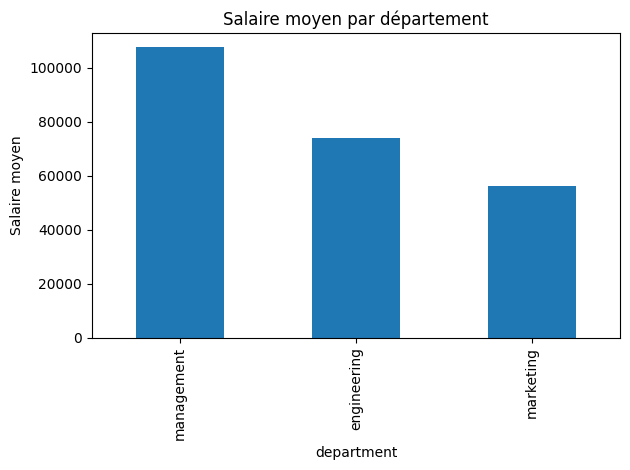

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col
import pandas as pd
import matplotlib.pyplot as plt
import os, socket, traceback

# Detect cluster mode via env set in docker-compose
spark_master = os.environ.get('SPARK_MASTER')

# Resolve paths: in containers, repo is mounted at /data (RO), so CSVs live under /data/data
cwd = os.getcwd()
project_root = os.path.abspath(os.path.join(cwd, '..'))
local_data = os.path.join(project_root, 'data')
cluster_data = '/data/data'
cluster_shared = '/shared'

if spark_master:
    data_dir = cluster_data
    output_dir = cluster_shared
else:
    data_dir = local_data
    output_dir = os.path.join(project_root, 'output')

sample_csv = os.path.join(data_dir, 'sample.csv')
print('Mode:', 'cluster' if spark_master else 'local')
print('Reading sample from:', sample_csv)
print('Writing outputs to:', output_dir)

# Stop previous SparkSession if any
try:
    spark.stop()
except Exception:
    pass

# Prefer explicit env; in docker-compose, workers can resolve 'jupyter'
driver_host = os.environ.get('SPARK_DRIVER_HOST') or ('jupyter' if spark_master else socket.gethostname())

# Build SparkSession with safe defaults (UI disabled to avoid MetricsSystem issues)
builder = (
    SparkSession.builder
    .appName('notebook')
    .config('spark.ui.enabled', 'false')
)

if spark_master:
    print('Using cluster mode with master:', spark_master)
    print('Setting spark.driver.host ->', driver_host)
    builder = (
        builder
        .master(spark_master)
        .config('spark.driver.host', driver_host)
        .config('spark.driver.bindAddress', '0.0.0.0')
    )
else:
    print('No SPARK_MASTER -> using local[*]')
    builder = builder.master('local[*]')

try:
    spark = builder.getOrCreate()
except Exception as e:
    print('SparkSession.getOrCreate() failed:', e)
    traceback.print_exc()
    print('Retrying with event log disabled')
    builder = builder.config('spark.eventLog.enabled', 'false')
    spark = builder.getOrCreate()

sc = spark.sparkContext
print('Spark master:', sc.master)
print('Spark version:', spark.version)
print('spark.driver.host:', spark.conf.get('spark.driver.host'))

# Load sample CSV and display
df = spark.read.option('header', True).option('inferSchema', True).csv(sample_csv)
print('--- Schéma ---')
df.printSchema()
print('--- Aperçu ---')
df.show(10, truncate=False)

# Aggregation
agg = df.groupBy('department').agg(avg(col('salary')).alias('avg_salary'))
agg_pd = agg.toPandas().sort_values('avg_salary', ascending=False)

# Plot
display(agg_pd)
ax = agg_pd.plot.bar(x='department', y='avg_salary', legend=False)
ax.set_title('Salaire moyen par département')
ax.set_ylabel('Salaire moyen')
plt.tight_layout()
plt.show()

In [7]:
# Diagnostic map-side join
import json
import urllib.request
import time

def diag_map_side(adj, ranks, spark):
    sc = spark.sparkContext

    # 1) partitioner info
    print("adj.partitioner:", adj.partitioner)
    print("ranks.partitioner:", ranks.partitioner)
    same_partitioner = (adj.partitioner is not None and ranks.partitioner is not None and
                        type(adj.partitioner) == type(ranks.partitioner) and
                        getattr(adj.partitioner, 'numPartitions', None) == getattr(ranks.partitioner, 'numPartitions', None))
    print("Same partitioner type & numPartitions?:", same_partitioner)

    # 2) matérialiser si besoin et lister keys par partition
    print("Materialize (persist + count) to ensure partitioning is effective...")
    adj.persist()
    ranks.persist()
    adj.count(); ranks.count()

    def keys_by_partition(pair_rdd):
        # retourne [(partitionIndex, [keys...]), ...]
        return sorted(pair_rdd.mapPartitionsWithIndex(
            lambda idx, it: [(idx, [k for (k, _v) in it])]).collect(), key=lambda x: x[0])

    try:
        keys_adj = keys_by_partition(adj)
        keys_ranks = keys_by_partition(ranks)
        print("Keys per partition (adj):")
        for idx, ks in keys_adj:
            print(f"  part {idx}: {ks[:10]}{'...' if len(ks)>10 else ''} (count={len(ks)})")
        print("Keys per partition (ranks):")
        for idx, ks in keys_ranks:
            print(f"  part {idx}: {ks[:10]}{'...' if len(ks)>10 else ''} (count={len(ks)})")
    except Exception as e:
        print("Erreur en listant keys par partition:", e)

    # 3) faire le join et inspecter joined par partition
    print("\\nPerforming join and inspecting joined contents per partition (sample)...")
    joined = adj.join(ranks)   # (key, (neighbors, rank))
    joined_parts = sorted(joined.mapPartitionsWithIndex(lambda idx, it: [(idx, list(it))]).collect(), key=lambda x: x[0])
    for idx, items in joined_parts:
        print(f"Partition {idx}: {len(items)} records (sample keys: {[k for (k,_) in items][:10]})")

    # 4) interroger Spark UI REST pour chercher shuffle bytes par stage
    try:
        appId = sc.applicationId
        ui = sc.uiWebUrl  # ex: http://localhost:4040
        if not ui:
            print("Spark UI non accessible (uiWebUrl vide). Ouvre manuellement le Spark UI pour vérifier les shuffles.")
            return
        base = ui.rstrip('/') + f"/api/v1/applications/{appId}"
        stages_url = base + "/stages"
        print("\\nQuerying Spark REST API:", stages_url)
        stages = json.loads(urllib.request.urlopen(stages_url).read().decode())
        print(f"Found {len(stages)} stages for app {appId}. Summarizing shuffle bytes per stage (may be slow)...")
        # Pour chaque stage, interroger la liste des tâches et sommer shuffle metrics
        for s in sorted(stages, key=lambda x: (x.get('submissionTime') or ''))[-10:]:  # dernières 10 stages
            sid = s.get('id')
            name = s.get('name')
            sub = s.get('submissionTime')
            comp = s.get('completionTime')
            # taskList endpoint (retourne tâches du stage)
            tasks_url = base + f"/stages/{sid}/taskList"
            try:
                tasks = json.loads(urllib.request.urlopen(tasks_url).read().decode())
                shuffle_read = 0
                shuffle_write = 0
                for t in tasks:
                    tm = t.get('taskMetrics') or {}
                    srm = tm.get('shuffleReadMetrics') or {}
                    swm = tm.get('shuffleWriteMetrics') or {}
                    # différentes versions de Spark exposent différents champs; on essaye les plus courants
                    shuffle_read += int(srm.get('remoteBytesRead', 0) or 0) + int(srm.get('localBytesRead', 0) or 0) + int(srm.get('fetchWaitTime', 0) or 0)
                    shuffle_write += int(swm.get('bytesWritten', 0) or 0) + int(swm.get('shuffleBytesWritten', 0) or 0)
                print(f"Stage {sid} | name={name} | submitted={sub} | completed={comp} | shuffle_read_bytes={shuffle_read} | shuffle_write_bytes={shuffle_write}")
            except Exception as e:
                print(f"  Stage {sid}: impossible d'interroger tasks ({e})")
        print("\\nSi la stage correspondant au join montre shuffle_write_bytes proche de 0, le join a probablement été map-side.")
        print("Tu peux ouvrir l'URL du Spark UI ci-dessous et regarder la Stage correspondant au join pour confirmer (Shuffle Read/Write).")
        print("Spark UI:", ui)
    except Exception as e:
        print("Erreur en interrogeant Spark UI REST:", e)

# Usage
# Exécute diag_map_side(adj, ranks, spark) après avoir persist+count() les deux RDDs.
# diag_map_side(adj, ranks, spark)

In [ ]:
# PageRank (exemple RDD) en utilisant map-side join si possible
# Lit edges.csv (colonnes: src,dst) et construit adjacency list partitionnée
import os

# Reuse paths decided in the first cell if present; otherwise compute reasonable defaults
spark_master = os.environ.get('SPARK_MASTER')
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
local_data = os.path.join(project_root, 'data')
cluster_data = '/data'
cluster_shared = '/shared'

if spark_master:
    data_dir = cluster_data
    out_dir = cluster_shared
else:
    data_dir = local_data
    out_dir = os.path.join(project_root, 'output')

edges_path = os.path.join(data_dir, 'edges.csv')
print('Reading edges from:', edges_path)

# Lire les edges en Pair-RDD (src, dst)
edges = sc.textFile(edges_path)
header = edges.first()
if 'src' in header.lower():
    edges = edges.filter(lambda l: l != header)
pairs = edges.map(lambda line: tuple(line.split(',')))

# Construire adjacency list: RDD[(src, [dst1,dst2,...])]
adj = pairs.groupByKey().mapValues(lambda it: list(it))
# Partitionner et persister l'adjacency (utile pour map-side join)
numParts = sc.defaultParallelism
adj = adj.partitionBy(numParts).persist()
adj.count()  # materialise

# Initial ranks: 1.0 pour chaque node présent dans adj keys ou values
nodes_from_src = adj.keys()
nodes_from_dst = pairs.map(lambda x: x[1])
all_nodes = nodes_from_src.union(nodes_from_dst).distinct().map(lambda n: (n, 1.0))
ranks = all_nodes.partitionBy(numParts).persist()
ranks.count()  # materialise

# PageRank iterations (map-side join via adj.join(ranks))
def pagerank(adj, ranks, iterations=10, damping=0.85):
    numParts = adj.getNumPartitions()
    for i in range(iterations):
        # s'assurer que ranks a le même partitioner
        ranks = ranks.partitionBy(numParts).persist()
        ranks.count()

        # join map-side car adj est partitionné et ranks a le même partitioner
        diag_map_side(adj, ranks, spark)
        joined = adj.join(ranks)  # (node, (neighbors, rank))

        # contributions: (neighbor, contrib)
        contribs = joined.flatMap(lambda kv: [(nbr, kv[1][1] / len(kv[1][0])) for nbr in kv[1][0]] if len(kv[1][0])>0 else [])

        # aggregate contributions (shuffle) puis apply damping
        new_ranks = contribs.reduceByKey(lambda a,b: a+b, numPartitions=numParts)
        new_ranks = new_ranks.mapValues(lambda v: (1 - damping) + damping * v).persist()
        new_ranks.count()

        ranks.unpersist()
        ranks = new_ranks
    return ranks

final = pagerank(adj, ranks, iterations=5)
out = final.collect()
print('PageRank result (node, rank):')
for n, r in sorted(out):
    print(n, r)

# Écrire le résultat en CSV avec en-tête dans un dossier partagé (un seul fichier via coalesce)
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'pagerank')
# Créer un DataFrame à partir de la liste collectée et écrire en CSV avec header
final_df = spark.createDataFrame(out, schema=['node', 'rank'])
final_df.coalesce(1).write.mode('overwrite').option('header', True).csv(out_path)
print('Résultats écrits dans', out_path)

# cleanup
adj.unpersist()
ranks.unpersist()


adj.partitioner: <pyspark.rdd.Partitioner object at 0x13ca97e90>
ranks.partitioner: <pyspark.rdd.Partitioner object at 0x13ca95f10>
Same partitioner type & numPartitions?: True
Materialize (persist + count) to ensure partitioning is effective...
Keys per partition (adj):
  part 0: [] (count=0)
  part 1: ['B'] (count=1)
  part 2: ['E', 'F'] (count=2)
  part 3: ['C'] (count=1)
  part 4: ['D', 'G'] (count=2)
  part 5: [] (count=0)
  part 6: ['A'] (count=1)
  part 7: [] (count=0)
Keys per partition (ranks):
  part 0: [] (count=0)
  part 1: ['B'] (count=1)
  part 2: ['E', 'F'] (count=2)
  part 3: ['C'] (count=1)
  part 4: ['G', 'D'] (count=2)
  part 5: [] (count=0)
  part 6: ['A'] (count=1)
  part 7: [] (count=0)
\nPerforming join and inspecting joined contents per partition (sample)...
Keys per partition (adj):
  part 0: [] (count=0)
  part 1: ['B'] (count=1)
  part 2: ['E', 'F'] (count=2)
  part 3: ['C'] (count=1)
  part 4: ['D', 'G'] (count=2)
  part 5: [] (count=0)
  part 6: ['A'] (coun

MapPartitionsRDD[137] at mapPartitions at PythonRDD.scala:160